Library used:  Fast ai

Fast ai library simplifies training fast and accurate neural nets using modern best practices. Fast ai is built on top of PyTorch and it provides many handy methods to tune the hyperparameters. See this link for more details : https://blog.floydhub.com/ten-techniques-from-fast-ai/

In [ ]:
! pip install -q kaggle
! pip install fastai

In [1]:
# Load Libraries


from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc,roc_curve

import os

In [0]:
# Clean Up data
#! rm -rf /content/*

In [ ]:
# Download and Extract Kaggle Data

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download  "kmader/skin-cancer-mnist-ham10000"

! mkdir raw_data 

In [7]:
! unzip skin-cancer-mnist-ham10000.zip -d raw_data

!unzip "raw_data/HAM10000_images_part_1.zip" -d "raw_data/HAM10000_images_part_1"
!unzip "raw_data/HAM10000_images_part_2.zip" -d "raw_data/HAM10000_images_part_2"

Archive:  skin-cancer-mnist-ham10000.zip
  inflating: raw_data/hmnist_28_28_RGB.csv  
  inflating: raw_data/HAM10000_metadata.csv  
  inflating: raw_data/HAM10000_images_part_1.zip  
  inflating: raw_data/hmnist_28_28_L.csv  
  inflating: raw_data/hmnist_8_8_L.csv  
  inflating: raw_data/HAM10000_images_part_2.zip  
  inflating: raw_data/hmnist_8_8_RGB.csv  
Archive:  raw_data/HAM10000_images_part_1.zip
  inflating: raw_data/HAM10000_images_part_1/ISIC_0024306.jpg  
  inflating: raw_data/HAM10000_images_part_1/ISIC_0024307.jpg  
  inflating: raw_data/HAM10000_images_part_1/ISIC_0024308.jpg  
  inflating: raw_data/HAM10000_images_part_1/ISIC_0024309.jpg  
  inflating: raw_data/HAM10000_images_part_1/ISIC_0024310.jpg  
  inflating: raw_data/HAM10000_images_part_1/ISIC_0024311.jpg  
  inflating: raw_data/HAM10000_images_part_1/ISIC_0024312.jpg  
  inflating: raw_data/HAM10000_images_part_1/ISIC_0024313.jpg  
  inflating: raw_data/HAM10000_images_part_1/ISIC_0024314.jpg  
  inflating: raw_

In [8]:
# Combine dataset into single folder
!mkdir "raw_data/HAM10000_images"

import glob
import shutil
folder1  = glob.glob("raw_data/HAM10000_images_part_1/*.jpg")
folder2  = glob.glob("raw_data/HAM10000_images_part_2/*.jpg")

for file in folder1:
  shutil.copy2(file,"raw_data/HAM10000_images")
for file in folder2:
  shutil.copy2(file,"raw_data/HAM10000_images")

In [2]:
# Path
path='raw_data'
csv_file='raw_data/HAM10000_metadata.csv'

In [3]:
# Read MetaData
df=pd.read_csv(csv_file).set_index('image_id')
df.head()


,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear


In [4]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
df.dx=df.dx.astype('category',copy=True)
df['labels']=df.dx.cat.codes # Convert the labels to numbers
df['lesion']= df.dx.map(lesion_type_dict)
df.head()

,lesion_id,dx,dx_type,age,sex,localization,labels,lesion
image_id,,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,2,Benign keratosis
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,2,Benign keratosis


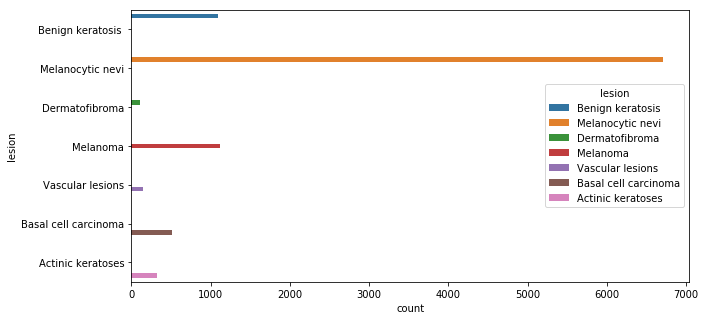

In [6]:
# Plot data distribution
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=df, hue="lesion",ax=ax1)

In [7]:
class CustomImageItemList(ImageItemList):
    def custom_label(self,df, **kwargs)->'LabelList':
        """Custom Labels from path"""
        file_names=np.vectorize(lambda files: str(files).split('/')[-1][:-4])
        get_labels=lambda x: df.loc[x,'lesion']
        labels= get_labels(file_names(self.items))
        y = CategoryList(items=labels)
        res = self._label_list(x=self,y=y)
        return res

In [8]:
def get_data(bs, size):
    train_ds = (CustomImageItemList.from_folder('raw_data/HAM10000_images', extensions='.jpg')
                    .random_split_by_pct(0.15)
                    .custom_label(df)
                    .transform(tfms=get_transforms(flip_vert=True),size=size)
                    .databunch(num_workers=2, bs=bs)
                    .normalize(imagenet_stats))
    return train_ds

In [9]:
# Get data
data=get_data(16,224)

In [10]:
data.classes=list(np.unique(df.lesion))  
data.c= len(np.unique(df.lesion))  

ResNet is a short name for Residual Network. As the name of the network indicates, the new terminology that this network introduces is residual learning.

Deep convolutional neural networks have led to a series of breakthroughs for image classification. Many other visual recognition tasks have also greatly benefited from very deep models. So, over the years there is a trend to go more deeper, to solve more complex tasks and to also increase /improve the classification/recognition accuracy. But, as we go deeper; the training of neural network becomes difficult and also the accuracy starts saturating and then degrades also. Residual Learning tries to solve both these problems.

In general, in a deep convolutional neural network, several layers are stacked and are trained to the task at hand. The network learns several low/mid/high level features at the end of its layers. In residual learning, instead of trying to learn some features, we try to learn some residual. Residual can be simply understood as subtraction of feature learned from input of that layer. ResNet does this using shortcut connections (directly connecting input of nth layer to some (n+x)th layer. It has proved that training this form of networks is easier than training simple deep convolutional neural networks and also the problem of degrading accuracy is resolved.

This is the fundamental concept of ResNet.

ResNet50 is a 50 layer Residual Network

More details on: https://arxiv.org/pdf/1512.03385.pdf

In [11]:
# Model
learner=create_cnn(data,models.resnet50,metrics=[accuracy], model_dir="/tmp/model/")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


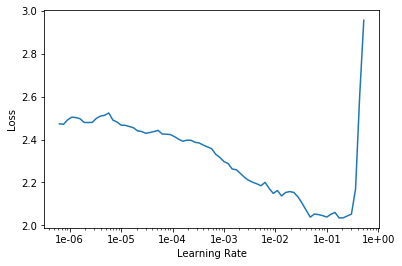

In [12]:
learner.loss_func=nn.CrossEntropyLoss()
learner.lr_find()
learner.recorder.plot()

In [20]:
learner.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy
1,0.852438,0.699996,0.753662
2,0.688453,0.645917,0.758322
3,0.684138,0.631347,0.782956
4,0.610337,0.525912,0.809587
5,0.571872,0.510159,0.813582
6,0.499503,0.458623,0.832889
7,0.489640,0.463291,0.829561
8,0.437609,0.437244,0.848202
9,0.396577,0.404954,0.842876
10,0.384876,0.400638,0.848868


In [21]:
learner.save("before_unfreeze")

In [22]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


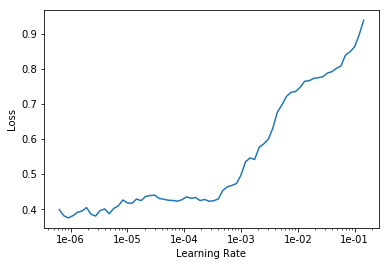

In [23]:
learner.lr_find()
learner.recorder.plot()

In [24]:
lr=1e-6
learner.fit_one_cycle(3, slice(3*lr,10*lr))

epoch,train_loss,valid_loss,accuracy
1,0.391912,0.404683,0.852197
2,0.365750,0.400725,0.856858
3,0.397416,0.389167,0.857523


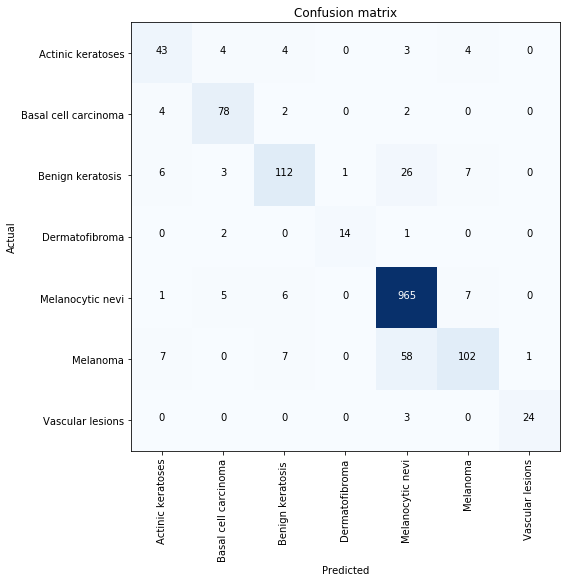

In [13]:
learner.save('stage-1')
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,8))

In [14]:
interp.most_confused()

[('Melanoma', 'Melanocytic nevi', 58),
 ('Benign keratosis ', 'Melanocytic nevi', 26),
 ('Benign keratosis ', 'Melanoma', 7),
 ('Melanocytic nevi', 'Melanoma', 7),
 ('Melanoma', 'Actinic keratoses', 7),
 ('Melanoma', 'Benign keratosis ', 7),
 ('Benign keratosis ', 'Actinic keratoses', 6),
 ('Melanocytic nevi', 'Benign keratosis ', 6),
 ('Melanocytic nevi', 'Basal cell carcinoma', 5),
 ('Actinic keratoses', 'Basal cell carcinoma', 4),
 ('Actinic keratoses', 'Benign keratosis ', 4),
 ('Actinic keratoses', 'Melanoma', 4),
 ('Basal cell carcinoma', 'Actinic keratoses', 4),
 ('Actinic keratoses', 'Melanocytic nevi', 3),
 ('Benign keratosis ', 'Basal cell carcinoma', 3),
 ('Vascular lesions', 'Melanocytic nevi', 3),
 ('Basal cell carcinoma', 'Benign keratosis ', 2),
 ('Basal cell carcinoma', 'Melanocytic nevi', 2),
 ('Dermatofibroma', 'Basal cell carcinoma', 2)]

From the classification matrix we could understand that the model is able to predict Melanocytic nevi accurately.

Classification of  Melanocytic nevi as other classes are minimal. This could be because the the amount of data in this class is quite high (can be seen from the distribution) and the features are learnt very well. 

In fact it has been overfitted to the level that it has misclassified  Melanoma and Benign keratosis to be Melanocytic nevi. It also due to the close resemblence of the images since Melanocytic nevi is benign neoplasms and melanoma is malignant neoplasm.

In [ ]:
# Predictions of the validation data
preds_val, y_val=learner.get_preds()

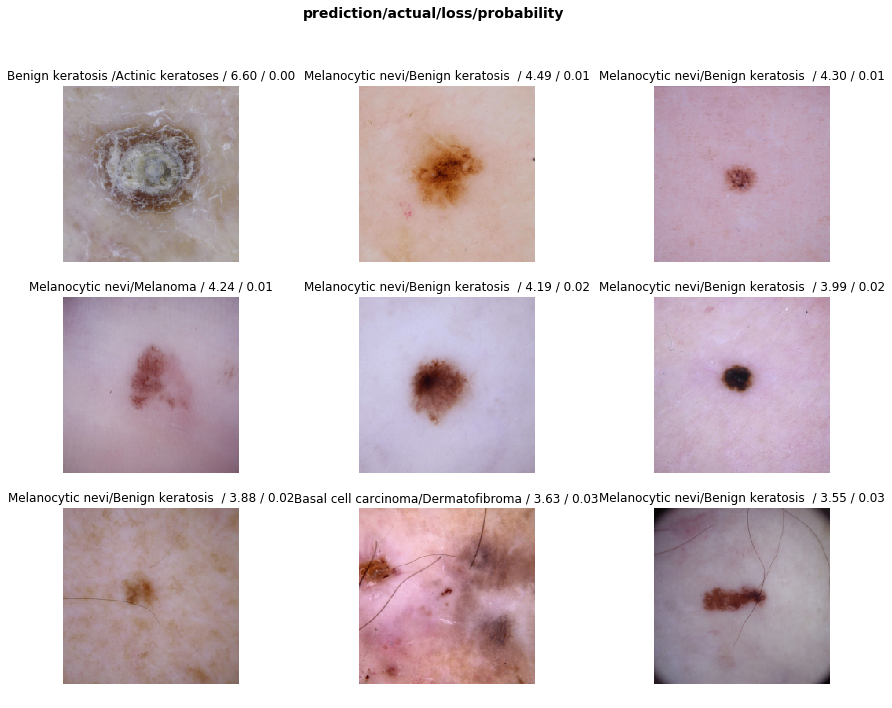

In [27]:
interp.plot_top_losses(9, figsize=(15,11))

In [28]:
#  ROC curve
fpr, tpr, thresholds = roc_curve(y_val.numpy(), preds_val.numpy()[:,1], pos_label=1)

#  ROC area
pred_score = auc(fpr, tpr)
print(f'ROC area is {pred_score}')

ROC area is 0.99366599590752


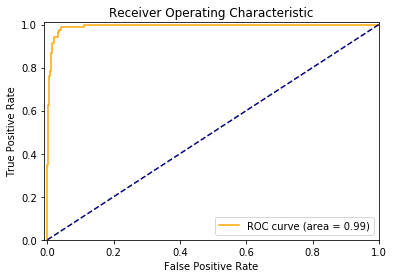

In [29]:
plt.figure()
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % pred_score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")